In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')
print("Modules imported")

Modules imported


In [2]:
# Common functions
def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings

In [3]:
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs


In [4]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    mi_scores = mutual_info_regression(X, y, discrete_features=False, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [5]:
# Read the dataset
penguins_data = pd.read_csv("datasets/penguins_lter.csv")

In [6]:
print(penguins_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   studyName            344 non-null    object 
 1   Sample Number        344 non-null    int64  
 2   Species              344 non-null    object 
 3   Region               344 non-null    object 
 4   Island               344 non-null    object 
 5   Stage                344 non-null    object 
 6   Individual ID        344 non-null    object 
 7   Clutch Completion    344 non-null    object 
 8   Date Egg             344 non-null    object 
 9   Culmen Length (mm)   342 non-null    float64
 10  Culmen Depth (mm)    342 non-null    float64
 11  Flipper Length (mm)  342 non-null    float64
 12  Body Mass (g)        342 non-null    float64
 13  Sex                  334 non-null    object 
 14  Delta 15 N (o/oo)    330 non-null    float64
 15  Delta 13 C (o/oo)    331 non-null    flo

In [7]:
# Let's pick some features as our training variables
feature_columns = ['Species', 'Island', 'Stage',
        'Culmen Length (mm)','Culmen Depth (mm)',
        'Flipper Length (mm)', 'Body Mass (g)', 'Sex']
X = penguins_data[feature_columns]

In [8]:
# This is likely a data entry mistake, hence we'll set it as a NaN for now
X.loc[X.Sex == '.', 'Sex'] = np.nan

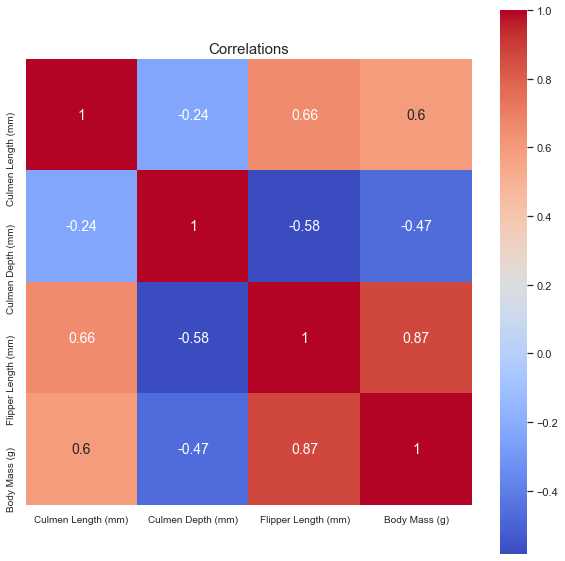

In [9]:
# Let's see the correlation heatmap
fig, axs = plt.subplots(nrows=1, figsize=(10, 10))

# most correlated features if too much features
#corrmat = train.corr()
#top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.5]
#plt.figure(figsize=(10,10))
#g = sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

sns.heatmap(X.corr(), ax=axs, annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})

axs.tick_params(axis='x', labelsize=10)
axs.tick_params(axis='y', labelsize=10)
    
axs.set_title('Correlations', size=15)

plt.show()

In [10]:
#Missing Values

def display_missing(df):    
    for col in df.columns.tolist():          
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')
    
display_missing(X)

Species column missing values: 0
Island column missing values: 0
Stage column missing values: 0
Culmen Length (mm) column missing values: 2
Culmen Depth (mm) column missing values: 2
Flipper Length (mm) column missing values: 2
Body Mass (g) column missing values: 2
Sex column missing values: 11




In [11]:
# Label Encoding
lbl = LabelEncoder()
label_encode_features = ['Sex', 'Stage', 'Species']
for feature in label_encode_features:
    X[feature] = lbl.fit_transform(X[feature])
    
# One-hot encoding
X = pd.get_dummies(X, prefix=['Island'], columns=['Island'])

# MICE Impute
imp = IterativeImputer(verbose=1)
imputed_X = imp.fit_transform(X)
imputed_X = pd.DataFrame(imputed_X, columns=X.columns)
X = imputed_X

[IterativeImputer] Completing matrix with shape (344, 10)
[IterativeImputer] Change: 1068.7236217544025, scaled tolerance: 6.3 
[IterativeImputer] Change: 321.20921154276783, scaled tolerance: 6.3 
[IterativeImputer] Change: 101.21690134372227, scaled tolerance: 6.3 
[IterativeImputer] Change: 33.45717756952766, scaled tolerance: 6.3 
[IterativeImputer] Change: 11.367061450522986, scaled tolerance: 6.3 
[IterativeImputer] Change: 3.9269288252807115, scaled tolerance: 6.3 
[IterativeImputer] Early stopping criterion reached.


In [13]:
# We can try to group it by species and sex as well.
'''
culmen_length_grouped = X.groupby(['Sex', 'Species']).median()['Culmen Length (mm)']

for Species in X.Species.unique():
    for sex in ['MALE', 'FEMALE']:
        print('Median age of Pclass {} {}s: {}'.format(pclass, sex, culment_length_grouped[sex][species]))
print('Median age of all passengers: {}'.format(df_all['Age'].median()))
df_all['Culmen Length (mm)'] = df_all.groupby(['Sex', 'Species'])['Culmen Length (mm)'].apply(lambda x: x.fillna(x.median()))
'''

"\nculmen_length_grouped = X.groupby(['Sex', 'Species']).median()['Culmen Length (mm)']\n\nfor Species in X.Species.unique():\n    for sex in ['MALE', 'FEMALE']:\n        print('Median age of Pclass {} {}s: {}'.format(pclass, sex, culment_length_grouped[sex][species]))\nprint('Median age of all passengers: {}'.format(df_all['Age'].median()))\ndf_all['Culmen Length (mm)'] = df_all.groupby(['Sex', 'Species'])['Culmen Length (mm)'].apply(lambda x: x.fillna(x.median()))\n"

In [14]:
#df_all_corr = X.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
#df_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
#df_all_corr[df_all_corr['Feature 1'] == 'Culmen Length (mm)']

In [15]:
def imputation_regressor(X, y):
    """
    We create a linear regression model to predict missing values here
    """
    regress_train_X, regress_test_X, regress_train_y, regress_test_y = train_test_split(X.dropna(), y.dropna(), random_state=1)
    clf = LinearRegression()
    clf.fit(regress_train_X, regress_train_y)
    y_test_pred = clf.predict(regress_test_X)
    print(f'R2 Score: {r2_score(regress_test_y, y_test_pred)}')
    return clf

#regress_X = X[['Flipper Length (mm)', 'Body Mass (g)']]
#regress_y = X['Culmen Length (mm)']
#clf = imputation_regressor(regress_X, regress_y)

# This doesn't work because flipper length and body mass are all null, still useful information nonetheless
# X['Culmen Length (mm)'] = clf.predict(regress_X)[X['Culmen Length (mm)'].isnull()]

In [16]:
# Feature Engineering
# We set the species column as the target variable to be predicted
y = X.Species
X.drop(columns=['Species'], inplace=True)

pca_features = ['Culmen Length (mm)', 'Flipper Length (mm)', 'Culmen Depth (mm)', 'Body Mass (g)']
pca, X_pca, loadings = apply_pca(X[pca_features])

In [17]:
mi_scores = make_mi_scores(X_pca, y)
mi_scores

PC1    0.824028
PC3    0.299924
PC2    0.169069
PC4    0.023154
Name: MI Scores, dtype: float64